# Prerequisites
- Hashes

# Theory

- [good blog post](https://medium.com/@StevieCEllis/the-beautiful-hash-algorithm-f18d9d2b84fb)

**Task**
- Construct collision resistant hash functions

*Idea*
- Start from a short collision resistant function
- Build a bigger collision resistant function

## Merkle-Damgard paradigm

### The construction

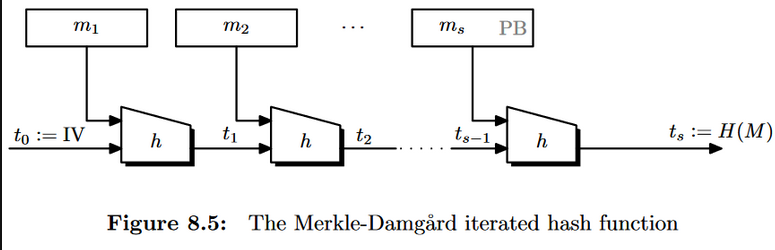
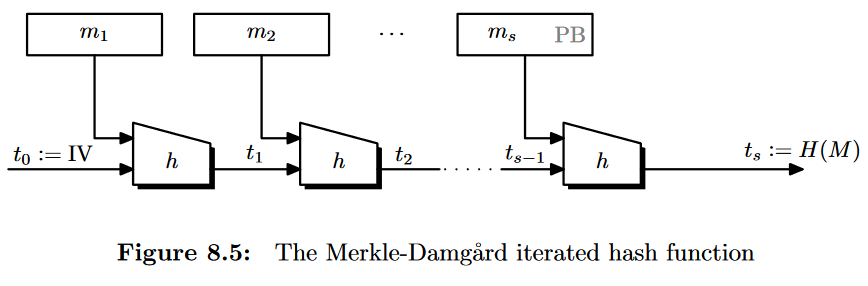

Let 
- $h:\mathcal{X}\times \mathcal{Y} \to \mathcal{X}$ be a compression hash function
    - The name compression is because you take a bigger input and map it to a smaller one
    - Usually $\mathcal{X} = \{0,1\}^n$ and $\mathcal{Y} = \{0,1\}^l$
- $IV$ = initial value and it's **fixed**
- $m_1, ... m_s$ = message blocks in $\mathcal{Y}$
- $t_0, ... t_1$ = chaining variables in $\mathcal{X}$
- $PB$ = padding block

**Merkle-Damgard Construction**
- Pad $M$ using a padding scheme => $M' = M || PB$
- Divide $M' \in \{0,1\}^L$ into $s$ blocks of length $l$
    - $M' = m_1 || m_2 ||...|| m_s$ where $m_i \in \{0,1\}^l$
- $t_0 = IV \in \mathcal{X}$
- for $i=1$ to $s$
    - $t_i = h(t_{i-1}, m_i)$
- return $t_s \in \mathcal{X}$

We denote the above Merkel-Damgard function derived from $h$ with $H_{MD}$ 

**Example**
- SHA256 is a Merkle-Damgard function where $l = 512$ and $n = 256$

### The padding block

Let's look at $PB$ - the padding block

Format
- $PB = 100...00 |s$
- $s$ = the number of blocks
    - Usually $s$ is on 64 bits => messages $<2^{64}$ blocks are accepted
- $1$ is used to identify the poistion where the pad ends

### Security

**Theorem**
> If $h$ is collision resistant then the Merkle-Damgard hash function $H_{MD}$ derived from $h$ is collision resistant

**Proof**
- We want to show that starting from a collision in $H_{MD}$ we find a collision in $h$
- Suppose the attacker finds  $M \neq M'$ s.t $H_{MD}(M) = H_{MD}(M')$
    - Let $M = m_1...m_u$ with $t_1,... t_u$
    - Let $M' = m'_1...m'_v$ with $t'_1,... t'_v$
- We work from the last block backwards
    - Since $H_{MD}(M) = H_{MD}(M')$ then $h(t_{u-1}, m_u) = h(t'_{v-1}, m'_v)$
    - if $t_{u-1} \neq t'_{v-1})$ or $m_u \neq m'_v$ then we have a collision on $h$ -> Finished
    - else $t_{u-1} = t'_{v-1})$ and $m_u = m'_v$ => We have the same padding blocks => $u = v$
- Since we know $t_{u-1} = t'_{u-1}$ we repeat the process
    - If we find a collision -> We are finished
- Suppose there are no collisions => $m_i = m'_i$ for $1\leq i \leq u => M = M'$ => Contradicts the fact that $M$ and $M'$ were a collision
    

## Constructing Compression functions

### Davies-Meyer

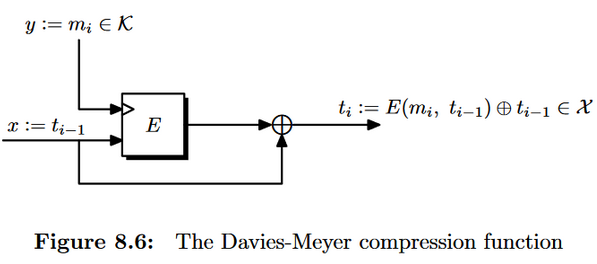
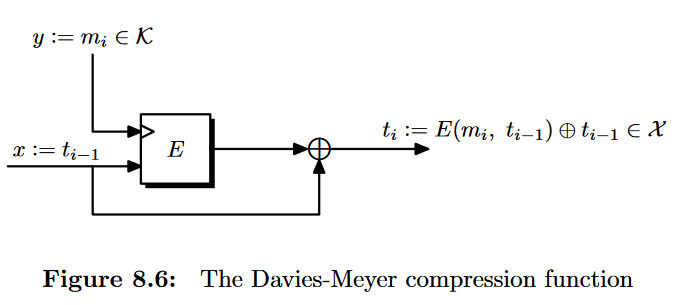

Since block ciphers are secure and fast constructions we are using a block cipher to construct our compression function
- Let $(E,D)$ be a block cipher defined over $(\mathcal{K}, \mathcal{X})$
- Let $h_{DM}:\mathcal{X} \times \mathcal{K} \rightarrow \mathcal{X}$ be our compression function
- $h_{DM}(x,y) = E(y,x) \oplus x$
- For 
    - $x = t_i \in \mathcal{X}$ -> the chaining variable is the input
    - $y = m_i \in \mathcal{K}$ -> the message is the key
    - $\boxed{h_{DM}(t_i,m_i) = E(m_i,t_i) \oplus t_i} \in \mathcal{X}$


Of course there are multiple ways to xor stuff, some are secure some aren't
- https://en.wikipedia.org/wiki/One-way_compression_function

**Theorem**
> If (E,D) is an *ideal* block cipher => finding a collision takes $\sqrt{|X|}$ - same as birthday attack => best as possible

### Hard problems

We can also build compression functions based on hard problems
- The security is based on the hardness of the problem => To find a collision it means finding a solution to an underlying hard problem
- Usually these functions are way slower than block ciphers and therefore are not used in practice

## SHA256

- Merkle-Damgard construction
- Davies-Meyer compression function $h$
- $h:\{0,1\}^{256} \times \{0,1\}^{512} \longrightarrow \{0,1\}^{256}$
    - SHACAL-2 block cipher
    - Splits the message into 512 bit blocks
    - $IV =6A09E667 BB67AE85 3C6EF372 A54FF53A 510E527F 9B05688C 1F83D9AB 5BE0CD19$
    - Instead of XOR, SHA256 uses adition mod $2^{32}$

# Code

## SHA256

- Merkle-Damgard construction
- Davies-Meyer compression function $h$
- $h:\{0,1\}^{256} \times \{0,1\}^{512} \longrightarrow \{0,1\}^{256}$
    - SHACAL-2 block cipher
        - https://crypto.stackexchange.com/questions/25233/shacal-2-vs-aes-as-underlying-block-cipher-for-secure-hash-aka-sha-256
    - Splits the message into 512 bit blocks
    - $IV =6A09E667 BB67AE85 3C6EF372 A54FF53A 510E527F 9B05688C 1F83D9AB 5BE0CD19$
    - Instead of XOR, SHA256 uses adition mod $2^{32}$

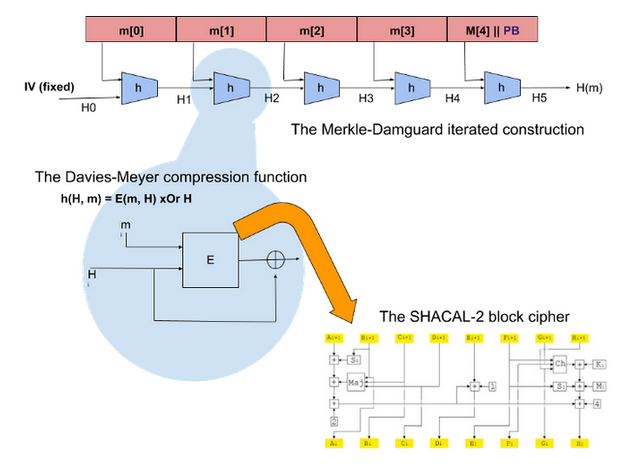
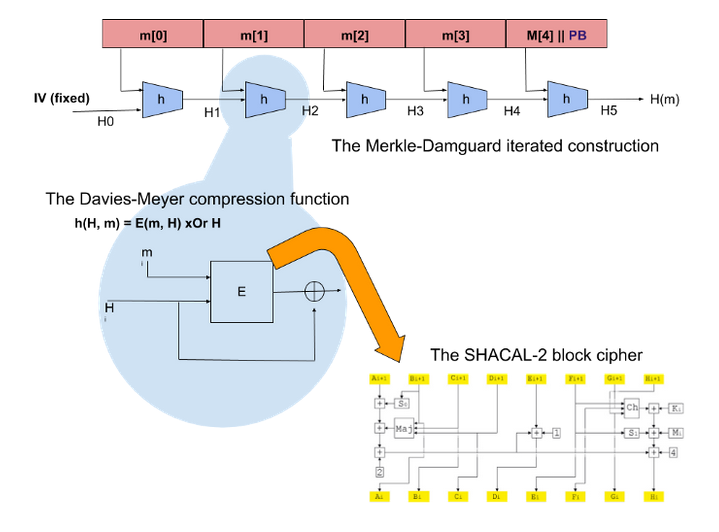

In [82]:
import hashlib

from Crypto.Hash.SHA256 import SHA256Hash
from Crypto.Util.number import bytes_to_long, long_to_bytes

In [83]:
def shr(x: int, n: int) -> int:
    """Mask 32b and shift right n bits"""
    return (x & 0xFFFFFFFF) >> n


def rotr(x: int, n: int) -> int:
    """Rotate right n bits and mask 32b"""
    return ((x >> n) | (x << (32 - n))) & 0xFFFFFFFF


def ch(x, y, z):
    # Ch(x,y,z)=(x∧y)⊕(¬x∧z)
    return z ^ (x & (y ^ z))


def maj(x, y, z):
    return (x & y) ^ (x & z) ^ (y & z)


def sigma0(x):
    return rotr(x, 7) ^ rotr(x, 18) ^ shr(x, 3)


def sigma1(x):
    return rotr(x, 17) ^ rotr(x, 19) ^ shr(x, 10)


def big_sigma0(x):
    return rotr(x, 2) ^ rotr(x, 13) ^ rotr(x, 22)


def big_sigma1(x):
    return rotr(x, 6) ^ rotr(x, 11) ^ rotr(x, 25)


def split_blocks(x: int, block_size: int, n_blocks: int):
    """split x into n_blocks of block_size"""
    res = []
    mask = (1 << block_size) - 1
    for i in range(n_blocks):
        r = (x >> (block_size * i)) & mask
        res.insert(0, r)  # last block should be last in list so we insert in front
    return res

In [84]:
print(f"{0b10101:032b}")
print(f"{shr(0b10101, 2):032b}")
print(f"{rotr(0b10101, 2):032b}")

00000000000000000000000000010101
00000000000000000000000000000101
01000000000000000000000000000101


In [85]:
x = 0x6A09E667BB67AE853C6EF372A54FF53A510E527F9B05688C1F83D9AB5BE0CD19
y = split_blocks(x, 32, 8)
print([hex(i) for i in y])

['0x6a09e667', '0xbb67ae85', '0x3c6ef372', '0xa54ff53a', '0x510e527f', '0x9b05688c', '0x1f83d9ab', '0x5be0cd19']


Notation
- `x` = an int, `xs` the int split into blocks / words
    - `t` = the chaining variable, `ts` = t split into words of 32b
    - `m` = the chaining variable, `ms` = m split into words of 32b
    - `M` = the message, `Ms` = the message split into blocks of 512b
    - `Ws` = the round keys as 64 words of 32b

In [86]:
class SHA256:
    def __init__(self):

        self.mask = 0xFFFFFFFF
        # self.iv = 0x6A09E667BB67AE853C6EF372A54FF53A510E527F9B05688C1F83D9AB5BE0CD19
        self.iv = [0x6A09E667, 0xBB67AE85, 0x3C6EF372, 0xA54FF53A, 0x510E527F, 0x9B05688C, 0x1F83D9AB, 0x5BE0CD19]
        self.Ks = [
            0x428A2F98,
            0x71374491,
            0xB5C0FBCF,
            0xE9B5DBA5,
            0x3956C25B,
            0x59F111F1,
            0x923F82A4,
            0xAB1C5ED5,
            0xD807AA98,
            0x12835B01,
            0x243185BE,
            0x550C7DC3,
            0x72BE5D74,
            0x80DEB1FE,
            0x9BDC06A7,
            0xC19BF174,
            0xE49B69C1,
            0xEFBE4786,
            0x0FC19DC6,
            0x240CA1CC,
            0x2DE92C6F,
            0x4A7484AA,
            0x5CB0A9DC,
            0x76F988DA,
            0x983E5152,
            0xA831C66D,
            0xB00327C8,
            0xBF597FC7,
            0xC6E00BF3,
            0xD5A79147,
            0x06CA6351,
            0x14292967,
            0x27B70A85,
            0x2E1B2138,
            0x4D2C6DFC,
            0x53380D13,
            0x650A7354,
            0x766A0ABB,
            0x81C2C92E,
            0x92722C85,
            0xA2BFE8A1,
            0xA81A664B,
            0xC24B8B70,
            0xC76C51A3,
            0xD192E819,
            0xD6990624,
            0xF40E3585,
            0x106AA070,
            0x19A4C116,
            0x1E376C08,
            0x2748774C,
            0x34B0BCB5,
            0x391C0CB3,
            0x4ED8AA4A,
            0x5B9CCA4F,
            0x682E6FF3,
            0x748F82EE,
            0x78A5636F,
            0x84C87814,
            0x8CC70208,
            0x90BEFFFA,
            0xA4506CEB,
            0xBEF9A3F7,
            0xC67178F2,
        ]
        self.word_size = 32
        self.block_size = 512

    def hash(self, M: bytes):
        """
        Takes a message (bytes) M of variable block size, pads it and sends it to the Merkle-Damgard construction along with the iv
        Returns the hash as int
        """
        M = bytes_to_long(M)  # Transform message to int

        M_pad = self.pad2(M, self.block_size)  # pad message to block size
        ts = self.merkle_damgard_construction(M_pad, self.iv)
        t = 0
        for i, ti in enumerate(ts):
            t |= ti << (self.word_size * (7 - i))
        return long_to_bytes(t)

    def merkle_damgard_construction(self, M_pad, ts_init: list):
        """
        Input: M - Padded message ; ts - the initial 256b chaining variable as a list of 8 32b words
        Output: ts - final ts as a list of 8 32b words
        """
        s = len(long_to_bytes(M_pad)) * 8 // self.block_size
        ts = ts_init
        Ms = split_blocks(M_pad, 512, s)  # split the message into s blocks of 512b
        for m in Ms:
            ms = split_blocks(m, self.word_size, 16)  # split the message block into 16 32b words
            ts = self.davies_meyer_function(ms, ts)
        return ts

    def davies_meyer_function(self, ms: list, ts: list):
        """Input: ms - the message as 16 32b words; ts - the chaining variable as 8 32b words"""
        t_next = []
        es = self.encrypt_block(ms, ts)
        for ei, ti in zip(es, ts):
            t_next.append((ei + ti) & 0xFFFFFFFF)  # 32b addition
        return t_next

    def get_round_keys(self, ks: list):
        Ws = [0] * 64
        # copy the first 15
        for i, ki in enumerate(ks[:16]):
            Wi = ki
            Ws[i] = Wi
        # extent the rest
        for i in range(16, 64):
            Wi = (sigma1(Ws[i - 2]) + Ws[i - 7] + sigma0(Ws[i - 15]) + Ws[i - 16]) & self.mask
            Ws[i] = Wi

        return Ws

    def encrypt_block(self, ks: list, ts: list):
        """The block cipher"""
        Ws = self.get_round_keys(ks)

        a0, b0, c0, d0, e0, f0, g0, h0 = ts
        ai, bi, ci, di, ei, fi, gi, hi = a0, b0, c0, d0, e0, f0, g0, h0
        for i in range(64):
            T1 = (hi + big_sigma1(ei) + ch(ei, fi, gi) + self.Ks[i] + Ws[i]) & 0xFFFFFFFF
            T2 = big_sigma0(ai) + maj(ai, bi, ci)
            ai, bi, ci, di, ei, fi, gi, hi = (T1 + T2) & 0xFFFFFFFF, ai, bi, ci, (di + T1) & 0xFFFFFFFF, ei, fi, gi

        # res = ai << (32 * 7) | bi << (32 * 6) | ci << (32 * 5) | di << (32 * 4) | ei << (32 * 3) | fi << (32 * 2) | gi << (32 * 1) | hi
        # return res
        return ai, bi, ci, di, ei, fi, gi, hi

    def pad2(self, M, block_size):
        # long_to_bytes(bytes_to_long(''.encode())) has length 1 instead of 0
        if M != 0:
            # pad to a multiple of 8
            M_bits = M.bit_length()
            if M_bits % 8:
                M_bits = M_bits + 8 - (M_bits % 8)
            # equivalent to this
            # M_bits= len(long_to_bytes(M)) * 8 #this is better for shorter messages
        else:
            M_bits = 0

        res = (M << 1) | 1
        last_block_space = block_size - M_bits % block_size - 1
        # make space for the counter if necessary
        if last_block_space < 64:
            last_block_space += 512
        res = (res << last_block_space) | M_bits  # add the bit_length
        return res

In [87]:
sha256 = SHA256()
msg = b"hello world"

In [89]:
h = sha256.hash(msg)

In [110]:
h == hashlib.sha256(b"hello world").digest()

True

In [108]:
# https://www.di-mgt.com.au/sha_testvectors.html

test_vectors = [
    b"abc",
    b"",
    b"abcdbcdecdefdefgefghfghighijhijkijkljklmklmnlmnomnopnopq",
    b"abcdefghbcdefghicdefghijdefghijkefghijklfghijklmghijklmnhijklmnoijklmnopjklmnopqklmnopqrlmnopqrsmnopqrstnopqrstu",
    b"abcdefghbcdefghicdefghijdefghijkefghijklfghijklmghijklmnhijklmno" * 1024,  # the one in the doc is too long
]

In [109]:
m1 = b"Lorem ipsum dolor sit amet, consectetur adipiscing elit."
# test_vectors = [m1, m1 * 7, b"", b"hello⊕", b"\uE52D", m1 * 999]
for m in test_vectors:
    h1 = sha256.hash(m)
    h2 = hashlib.sha256(m).digest()
    print(h1 == h2)

True
True
True
True
True


# Resources

- [SHA2 wikipedia](https://en.wikipedia.org/wiki/SHA-2)
- [Computerphile video](https://www.youtube.com/watch?v=DMtFhACPnTY&t)